In [1]:
import sys  
sys.path.append(r'../source')  
import utils
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Origen de los datos

El fichero que contiene las opiniones que vamos a procesar y analizar se encuentra en la siguiente dirección:  https://nijianmo.github.io/amazon/index.html#files (enlace al fichero: http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz)

Este portal pertenece a la Universidad de California San Diego y es mantenido por Jianmo Ni Ph.D. Contiene multitud de datasets de opiniones de Amazon, clasificados por departamento (Books, Electronics, Software...). El fichero que se procesa en este trabajo es el correspondiente al departamento de Electronics. Se trata de un json de nombre Electronics_5. El número 5 indica que solo aparecen opiniones de productos que tengan, al menos, 5 opiniones.

# Análisis exploratorio sin entrar en el contenido

En esta sección vamos a visualizar las primeras líneas del fichero Electronics_5.json tal cual están en el fichero. A continuación generaremos y analizaremos el objeto data_raw_0, que es un DataFrame de Pandas en el cual se han realizado algunas transformaciones mínimas.

Veamos en primer lugar el contenido del fichero:

In [2]:
utils.get_first_lines_electronics_5(10)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400
5,4.0,NaN,True,"06 5, 2013",A3IYSOTP3HA77N,0380709473,{'Format:': ' Kindle Edition'},B. Marks,I read this probably 50 years ago in my youth ...,Above average mystery,1370390400
6,5.0,NaN,True,"06 27, 2016",A11SXV34PZUQ5E,0380709473,{'Format:': ' Kindle Edition'},Tom C.,I read every Perry mason book voraciously. Fin...,Lam is cool!,1466985600
7,5.0,NaN,True,"07 30, 2015",A2AUQM1HT2D5T8,0380709473,{'Format:': ' Kindle Edition'},ema,I love this series of Bertha and Lamb.. Great...,Five Stars,1438214400
8,5.0,NaN,True,"02 16, 2015",A3UD8JRWLX6SRX,0380709473,{'Format:': ' Paperback'},Michael O.,Great read!,Five Stars,1424044800
9,4.0,NaN,False,"11 21, 2013",A3MV1KKHX51FYT,0380709473,{'Format:': ' Paperback'},Acute Observer,"Crows Can't Count, A.A. Fair\n\nMr. Harry Shar...",A Fast and Far Moving Adventure,1384992000


Veamos los campos que componen el fichero y su significado, acorde a lo explicado en el portal original:
* overall: corresponde a la puntuación que el usuario ha otorgado al producto. Sus valores pueden ser 1, 2, 3, 4 o 5.
* vote: es la cantidad de votos que la opinión ha recibido. Estos votos indican que la opinión ha sido útil para otros usuarios.
* verified: booleano que indica si la compra está o no verificada por Amazon. Esta verificación permite a Amazon garantizar que el usuario que publica la opinión ha comprado, efectivamente, el producto del que está opinando.
* reviewTime: fecha de publicación de la opinión.
* reviewerID: ID de usuario que publica la opinión.
* asin: identificador único del producto.
* style: en algunos productos, este campo indica de qué formato o versión se trata. Vemos en estas primeras líneas que hay opiniones correspondientes a libros. Esto se debe a que algunos productos están duplicados en varias categorías.
* reviewerName: nombre del usuario que publica la opinión.
* reviewText: texto de la opinión. Aquí es de donde obtendremos la mayor parte de la información.
* summary: texto del resumen de la opinión. Suele ser un titular, unas pocas palabras.
* unixReviewTime: fecha de publicación de la opinión en formato Unix.

Para este trabajo no necesitamos todos los campos anteriores. Crearemos un nuevo objeto llamado data_raw_0, que es el resultado de leer el fichero original, Electronics_5.json, y trasladarlo a un DataFrame de Pandas. Por el camino realizamos un mínimo procesamiento que consiste en los siguiente:
* Transformamos el campo fecha en año, pues no necesitamos tanto detalle.
* Eliminamos algunos campos que no son de interés para este trabajo, concretamente los siguientes:
  * 'vote'
  * 'verified'
  * 'style'
  * 'reviewerName'
  * 'unixReviewTime'
  * 'image'
  * 'reviewTime'
* Sustituimos los nans por cadenas vacías. Esto lo hacemos tras comprobar que los únicos campos que presentan nans son los campos 'review' o 'summary', donde resulta más razonable, en el contexto de análisis de texto, que dichos campos sean cadenas vacías.

Vamos a mostrar varias representaciones del dataset para conocerlo un poco mejor. Enseguida veremos que el fichero Electronics_5.json contiene un gran sesgo hacia opiniones con una alta valoración. Este efecto es esperado, pues se conoce que las valoraciones de los productos en Amazon suelen altas. Ref: https://minimaxir.com/2014/06/reviewing-reviews/

Debido al análisis que se pretende hacer en este trabajo, eliminaremos el sesgo, dejando la misma cantidad de opiniones por cada valoración. Por este motivo el análisis exploratorio aparece dos veces, la primera sobre el dataset con sesgo y la segunda sin sesgo en la valoración.

In [3]:
data_raw_0 = utils.electronics_5_to_raw_data_0(1000000)

00h 00m 00s ____ INICIO FUNCIÓN ELECTRONICS_5_TO_RAW_DATA_0 ________________________________________
00h 00m 00s ____ INICIO FUNCIÓN GETDF ______________________________________________________________
00h 00m 09s :::: BUCLE RAW DATA: i=500000 de 1000000 :::::::::::::::::::::::::::::::::::::::::::::::
00h 00m 09s :::: BUCLE RAW DATA: i=1000000 de 1000000 ::::::::::::::::::::::::::::::::::::::::::::::
00h 00m 00s ____ FIN FUNCIÓN GETDF _________________________________________________________________
00h 00m 38s :::: SE PROCEDE A CREAR EL CAMPO OPINION_YEAR ::::::::::::::::::::::::::::::::::::::::::
00h 01m 06s :::: SE PROCEDE A ELIMINAR COLUMNAS QUE NO USAREMOS ::::::::::::::::::::::::::::::::::::
00h 00m 01s :::: SE PROCEDE A RENOMBRAR ALGUNAS COLUMNAS :::::::::::::::::::::::::::::::::::::::::::
00h 00m 00s :::: SE PROCEDE A SUSTITUIR LOS NANS POR CADENAS VACÍAS ::::::::::::::::::::::::::::::::
00h 00m 01s ____ FIN FUNCIÓN ELECTRONICS_5_TO_RAW_DATA_0 __________________________________

A continuación comprobamos que la distribución de puntuaciones está desplazada hacia valoraciones altas. Especialmente llamativa es la cantidad de opiniones con una valoración de 5 estrellas.

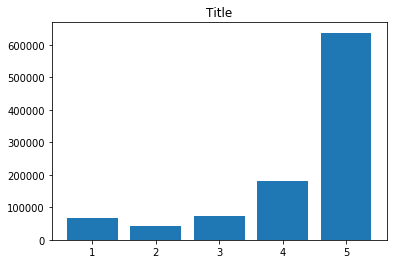

In [4]:
utils.perform_eda(data_raw_0, 'rating_distribution')

Comprobamos que si mostramos la misma información pero tomando la puntuación mediana por producto el efecto ese el mismo, incluso es algo más pronunciado:

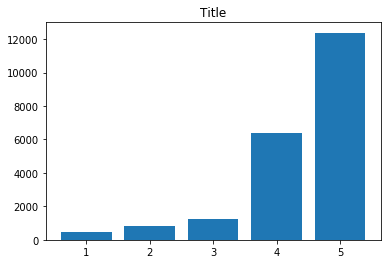

In [5]:
utils.perform_eda(data_raw_0, 'rating_distribution_item')

Veamos cuándo se registraron las opiniones de que disponemos:

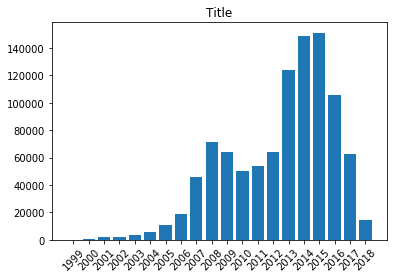

In [6]:
utils.perform_eda(data_raw_0, 'opinions_per_year')

El registro comienza en 1999 y termina en 2018, con un pico muy pronunciado entorno a los años 2014-2015.

Veamos ahora cuántas opiniones suelen tener los artículos.

Aparecen 21278 productos distintos en el dataset.


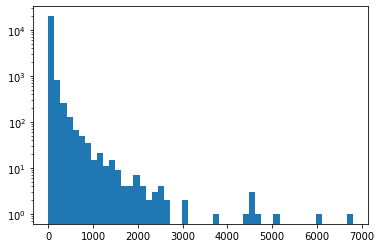

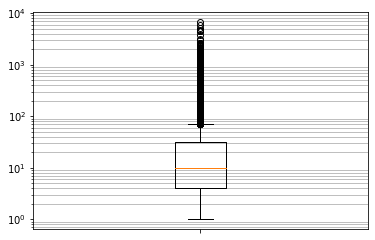

In [7]:
utils.perform_eda(data_raw_0, 'opinions_per_item')

Nótese la necesidad de una escala logarítmica. Si bien hay algunos artículos con una gran cantidad de opiniones (del orden de miles), también podemos ver que la mediana está situada en 9 opiniones.

Igual que con los artículos, veamos ahora cuántas opiniones hay por usuario.

Aparecen 407389 usuarios distintos en el dataset.


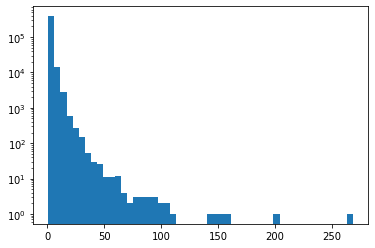

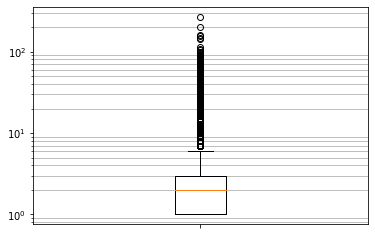

In [8]:
utils.perform_eda(data_raw_0, 'opinions_per_user')

Vemos que una gran cantidad de usuarios tienen apenas unas pocas opiniones.

¿Cómo es la dispersión en las puntuaciones? Lo vemos en el siguiente boxplot:

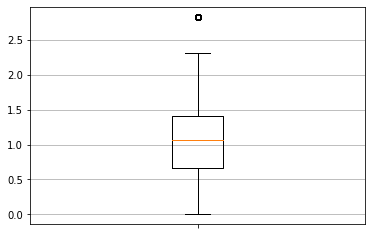

In [9]:
utils.perform_eda(data_raw_0, 'rating_sd_per_item')

La desviación estándar de las opiniones, calculada a nivel de artículo, tiene una mediana de 1, si bien puede llegar a ser bastante grande. Ninguna sorpresa aquí.

Veamos cuál es la longitud media de las opiniones según la puntuación, así como la proporción entre el resumen y el cuerpo de la opinión.

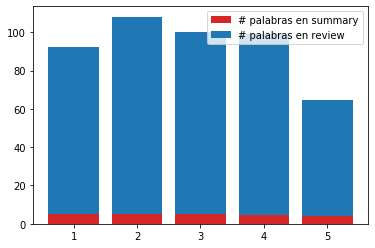

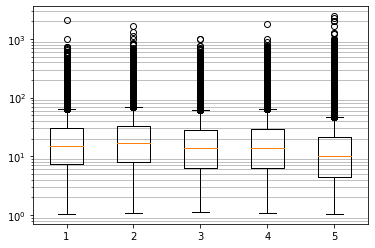

In [10]:
utils.perform_eda(data_raw_0, 'summary_review_length_comparison_per_rating')

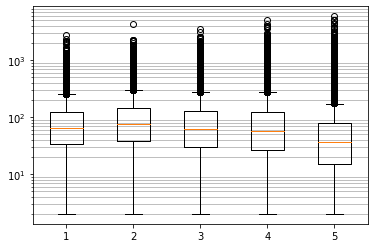

In [11]:
utils.perform_eda(data_raw_0, 'text_length_per_rating')

A continuación eliminamos el sesgo y repetimos la fase EDA.

Para eliminar el sesgo tomamos todas las opiniones de 2 estrellas, pues es el grupo menos poblado, y realizamos un sampleo aleatorio sobre el resto del datset. Tras este sampleo, el contenido del fichero Electronics_5.json que finalmente empleamos es aproximadamente un cuarto del total.

In [12]:
data_raw_1 = utils.remove_rating_bias_from_raw_data(data_raw_0)

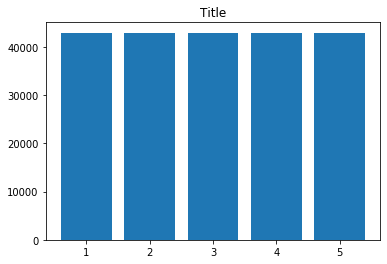

In [13]:
utils.perform_eda(data_raw_1, 'rating_distribution')

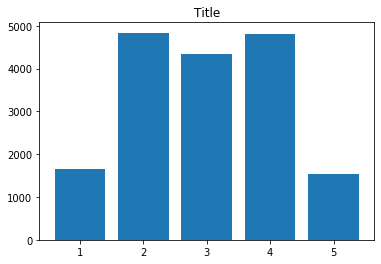

In [14]:
utils.perform_eda(data_raw_1, 'rating_distribution_item')

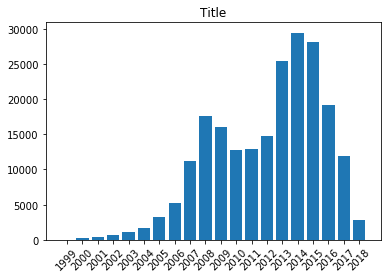

In [15]:
utils.perform_eda(data_raw_1, 'opinions_per_year')

Aparecen 17155 productos distintos en el dataset.


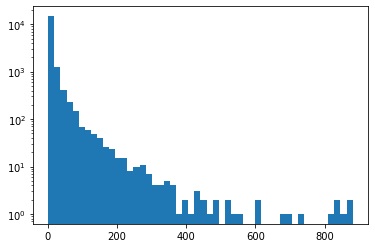

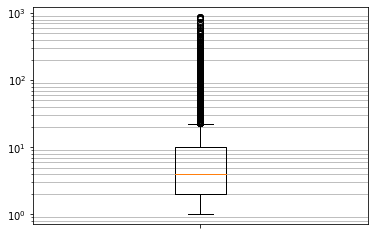

In [16]:
utils.perform_eda(data_raw_1, 'opinions_per_item')

Aparecen 150491 usuarios distintos en el dataset.


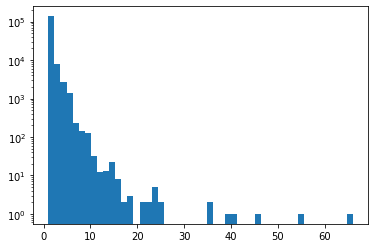

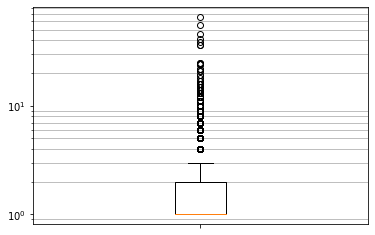

In [17]:
utils.perform_eda(data_raw_1, 'opinions_per_user')

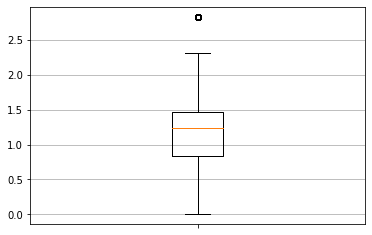

In [18]:
utils.perform_eda(data_raw_1, 'rating_sd_per_item')

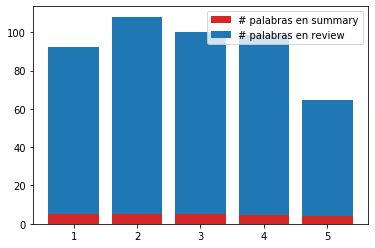

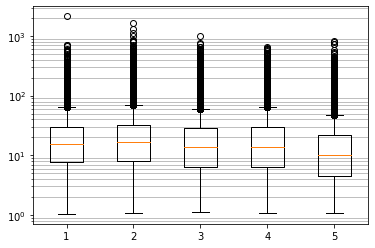

In [19]:
utils.perform_eda(data_raw_1, 'summary_review_length_comparison_per_rating')

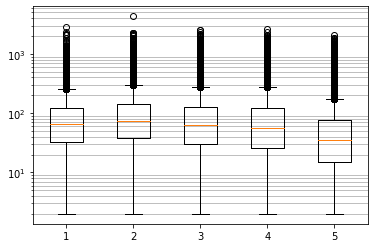

In [20]:
utils.perform_eda(data_raw_1, 'text_length_per_rating')

# Preparación de los datos

En esta sección tratamos el procesamiento de los datos. Los preparamos y le damos la estructura adecuada para realizar un análisis sobre ellos.

El objeto resultante del procesamiento lo llamaré odf (Opinion Data Frame) y será una pieza clave pues todos los análisis se harán sobre el mismo. Este objeto, de tipo pandas.DataFrame, contendrá tantas filas como opiniones (aproximadamente 1.5 millones) y los campos son los siguientes:
* doc_number
* rating
* text
* summary_raw
* review_raw
* summary_tokens_length

La construcción del objeto odf se realiza bajo la función execute_preprocessing_pipeline, que es una rutina que va ejecutando las distintas transformaciones que sufre el dataset suministrado, data_raw_1, hasta devolver el odf completo.

In [21]:
odf = utils.execute_preprocessing_pipeline(data_raw_1, False)
#odf = utils.load_latest_odf(nrows=1532805, is_false=True)

00h 00m 00s ____ INICIO FUNCIÓN EXECUTE_PREPROCESSING_PIPELINE _____________________________________
00h 00m 33s :::: SUMMARIES PROCESADOS ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
00h 07m 31s :::: REVIEWS PROCESADAS ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
00h 00m 00s ____ INICIO FUNCIÓN BUILD_ODF __________________________________________________________
00h 00m 00s :::: BUCLE GENERACIÓN VARIABLE TEXT: i=0 DE 214475 :::::::::::::::::::::::::::::::::::::
00h 00m 02s :::: BUCLE GENERACIÓN VARIABLE TEXT: i=200000 DE 214475 ::::::::::::::::::::::::::::::::
00h 00m 00s :::: VARIABLE TEXT GENERADA ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
00h 00m 02s :::: VARIABLE TEXT TRANSFORMADA ::::::::::::::::::::::::::::::::::::::::::::::::::::::::
00h 00m 00s ____ FIN FUNCIÓN BUILD_ODF _____________________________________________________________
00h 00m 05s :::: ODF_FALSE CONSTRUIDO :::::::::::::::::::::::::::::::::::::::::::::::::::::

# Análisis

El análisis que se lleva a cabo en este proyecto tiene por objetivo encontrar y mostrar de la mejor manera posible las relaciones que se establecen entre opiniones y temas. Por tanto, para realizar esta tarea vamos a necesitar dos partes previas a la extracción de insights:
* La detección, definición y construcción de temas
* La asignación de temas a opiniones

En las siguientes secciones se presentan las herramientas desarrolladas y los objetos definidos para llevar a cabo ambas partes.

Antes de ello, vamos a definir los elementos que van a ir apareciendo.
* Tema: definimos un tema como un elemento de negocio. Cada tema tratará de representar una parte del proceso de compra de un producto en un comercio electrónico. Por la manera en que se definen, los temas están naturalmente compuestos por subtemas (aunque no siempre hay una barrera clara entre subtemas) y estos, a su vez, por combinaciones de keywords. Los veremos más adelante pero, por poner un ejemplo, uno de los temas trata de la experiencia en la entrega del paquete. Algunos temas se definen por parejas (un tema para la experiencia positiva y otro para la negativa) y otros temas no tienen esa dualidad.
* Wordset: es el conjunto de palabras clave que constituyen un tema. No se trata simplemente de una lista sino que hay una cierta lógica, unas relaciones que deben cumplir los tokens con tal de considerarse un tema.
* Token: en este trabajo un token puede ser una palabra o un bigrama. Ejemplos de token pueden ser "package" o "works_great".
* Opinión: cuando usamos la palabra opinión nos referimos al objeto "Opinión", no al texto que escribe el usuario. La diferencia es que, en este análisis, la opinión es un objeto compuesto por varios campos: rating, review y summary.
* Rating: es la puntuación de una opinión. Siempre tiene un valor entre 1 y 5.
* Review: es el texto (largo) que escribe el usuario. Es, básicamente, lo que exploraremos para tratar de asignar temas a opiniones.
* Summary: es el resumen o el título de la review. Como hemos visto en el EDA, la longitud del summary suele ser bastante inferior a la de la review. También exploramos en los summaries para asignar temas a opiniones.
* Hit: asignación de un tema a una opinión.

# Herramientas y objetos

## Detección, definición y construcción de temas

Tras varios intentos fallidos de emplear métodos de Topic Modelling para la detección de los temas, decidí construir una metodología propia. Definí un tema como la estructura siguiente:

In [22]:
tema =  {
            'name': 'nombre del tema'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                            ,{
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                            ,...
                            ,{
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

El atributo name sencillamente identifica el tema.
El atributo wordset es el conjunto de palabras que identifican el tema. Su contenido se divide en dos piezas, los elementos "and" y los elementos "or". En el primer caso, todos los tokens que constituyen la lista de "ands" deben aparecer en el texto de la opinión (ya sea review o summary) con tal de que el algoritmo de búsqueda considere que se produce un hit. Los ors son el elemento más flexible. Es una lista de "grupos or". Cada grupo or contiene un concepto o bien una representación distinta de un mismo concepto, y el algoritmo de búsqueda considerará que se produce un hit si se satisface alguno de los grupos or.

La estructura de cada grupo or está compuesta de 4 listas. Una lista de sinónimos de tipo 0. Estos tokens suelen ser bigramas. Los sinónimos de tipo 1 requieren de un complemento, los sinónimos de tipo 2. Los nots son los tokens que, si se detectan próximas a un sinónimo de tipo 0 o 1 anulan el hit. Lo veremos con un ejemplo.

Vamos a ver el funcionamiento, tanto de los temas como del algoritmo de búsqueda, con unos ejemplos, pero primero veamos las opiniones sobre las que mostramos el funcionamiento:

In [23]:
odf_prueba = odf.loc[[148, 1455, 2689, 2849, 7213, 13890, 59018, 774310, 83236, 3161181, 5183314]]
for each in odf_prueba.iterrows():
    print('Opinión #', str(int(each[1]['doc_number']))+':')
    print('Rating:', str(int(each[1]['rating'])))
    print(each[1]['review_raw'], '\n\n********************************************\n')

ValueError: cannot convert float NaN to integer

Veamos el funcionamiento del elemento "ands".

In [ ]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['iphone']
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que se han localizado las 3 opiniones en las que aparece el token 'iphone':

Verificamos que si añadimos un token a la lista de "ands", la búsqueda es más restrictiva, pues solo harán hit las opiniones que contengan ambos tokens.

In [ ]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['iphone', 'charger']
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que la opinión 13890 deja de aparecer, pues no contiene la palabra "charger".

A continuación buscaremos opiniones que contengan alguno de los dos tokens. Para ello empleamos la lista syn0 del grupo or.

In [ ]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': ['iphone', 'charger'],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema, False)[0]['doc_number']

En esta ocasión aparecen todas las opiniones que contiene alguna de las dos (o las dos) palabras.

Ahora probemos una búsqueda algo más avanzada. Consideraremos 'phone' y 'iphone' como sinónimos, y exigiremos que aparezca el token 'charger'.

In [ ]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['charger']
                , 'ors': [
                            {
                            'syn0': ['iphone', 'phone'],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que se trata del resultado esperado: la opinión 7213 contiene "charger" y "phone" y las otras dos contienen "charger" y "iphone".

En esta ocasión vamos a mostrar la diferencia entre los syn0 y los sin1/syn2. Definimos un tema que considere la inestabilidad del producto. Los syn0 serán 'unstable' y 'stability_issues', mientras que el syn1 será 'stable', apoyado por el complemento 'not'.

In [ ]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': ['unstable',
                                     'stability_issues'],
                            'syn1': ['stable'],
                            'syn2': ['not'],
                            'nots': []
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema, False)[0]['doc_number']

Podemos comprobar fácilmente que ambas opiniones tratan el tema de la inestabilidad del producto.

Por último, veamos la importancia que puede tener el elemento 'not'. Para ello definimos dos temas iguales pero en uno de ellos le indicamos que los tokens 'not' y 'nor' no pueden aparecer próximos.

In [ ]:
tema1 =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': ['plug'],
                            'syn2': ['play'],
                            'nots': []
                            }
                         ]
            }
        }
tema2 =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': ['plug'],
                            'syn2': ['play'],
                            'nots': ['not']
                            }
                         ]
            }
        }

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema1, False)[0]['doc_number']

In [ ]:
utils.analize_wordset_not_so_naive_4(odf_prueba, tema2, False)[0]['doc_number']

Hasta aquí hemos visto cómo funcionan los temas una vez están definidos pero cómo los definimos? Mediante un proceso manual asistido por diversas herramientas para explorar los tokens del corpus.

En primer lugar, es fundamental disponer del corpus del dataset, es decir, los tokens que aparecen en las opiniones, y también cuántas veces aparecen. Para ello se ha desarrollado una función cuyo retorno es un objeto similar a un Bag Of Words. Lanzamos una muestra a continuación. Además de retornar la lista completa, podemos pedirle que nos muestre, en forma de wordcloud, los tokens más frecuentes.

In [ ]:
tokens = utils.generate_bow(odf, False, show=False)

Esa es la primera herramienta. Simplemente revisando manualmente los tokens más comunes es posible hacerse una idea de los temas que se tratan. Muchos de ellos no son útiles descontextualizados. Por ello, acudimos a los bigramas:

In [ ]:
utils.extract_bigrams_from_bow(tokens).head()

Los bigramas nos ofrecen una visión mucho más contextualizada. Si bien muchos de ellos no pueden ser interpretados por sí solos, sí hay otros muchos que sí lo permiten.

La siguiente herramienta nos asiste en la interpretación de los tokens. Nos sirve para contextualizarlos y adquirir una noción de "qué se suele decir" allí donde se usan. La función get_close_words nos devuelve los tokens más frecuentes que se encuentran antes (a la izquierda) del token buscado y las que se encuentran detrás (a la derecha). Asimismo, se recoge el número de ocasiones que aparecen e información sobre la puntuación: la media y la desviación estándar de aquellas opiniones en las que se ha encontrado el token seguido o precedido de cada palabra:

In [ ]:
utils.get_close_words_2(odf, 'defective', max_distance=3, n_words=8)

In [ ]:
utils.get_close_words_2(odf, 'works_great', max_distance=3, n_words=8)

Simplemente con esta función ya nos damos cuenta de que algunas palabras están fuertemente relacionadas con la puntuación de las opiniones, como podemos ver en estas dos ejecuciones.

Otra asistencia relacionada con la definición de los wordsets es la que nos ofrece la función busca_tokens. Esta función nos permite ver en qué bigramas aparece un token dado.

In [ ]:
utils.busca_tokens(tokens, ['quality'])

Estas son las herramientas que, combinadas entre ellas y con una cierta dedicación, me han permitido definir los wordsets de los temas.

## Asignación de temas a opiniones (hits)

El mecanismo de asignación de temas a opiniones lo hemos visto en la sección anterior. Es un algoritmo que recibe como inputs el odf y el envoltorio del wordset que queremos analizar. Además, podemos indicarle si queremos visualizar el histograma de los resultados por puntuación.

El código de la función analize_wordset está diseñado para seguir la siguiente lógica (la describimos de forma aproximada, ya que el código contiene matices para mejorar el rendimiento y la precisión):

* para cada opinión en el odf:
  * si se cumple la condición de los ands en el texto:
    * ands_compliance = True
    * si se cumple algún grupo or en el texto:
      * ors_compliance = True
  * si ands_compliance y ors_compliance:
    * se produce un hit

Algunos mecanismos que incluye el código para mejorar el rendimiento:
* Primero se realiza la búsqueda sobre el summary. De no satisfacerse las condiciones, entonces se busca en la review.
* No se procesa todo el texto (algunos son muy largos) sino que en primer lugar se localizan las posiciones de los tokens del wordset y entonces seleccionamos una porción del texto que los envuelve. De este modo reducimos drásticamente la longitud del texto a procesar. La porción de texto a estudiar se establece mediante un parámetro, max_distance, que se ha establecido en 3. Esto hace que el texto a estudiar sea, en muchas ocasiones, de tan solo 7 tokens.

Algunos mecanismos para mejorar la precisión:
* En la línea de establecer una distancia máxima de 3 tokens, esta es la distancia máxima a la que pueden estar los elementos syn1 y syn2 para ser contabilizados.
* De los elementos not, por su naturaleza, solo se comprueba su existencia en las max_distance posiciones previas al token de interés, no en las posteriores.

In [ ]:
tokens = utils.generate_bow(odf, False, show=False)
bigrams = utils.extract_bigrams_from_bow(tokens)

# Definición de temas y obtención de los hits

A continuación se muestran los temas que se han definido, así como el resultado de la función analize. Para cada caso, se mostrará un histograma donde podremos ver la distribución de los ratings.

In [ ]:
wsw1_pos =   {
            'name':'Funcionamiento (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # MUY POSITIVO
                    {
                    'syn0': ['works_great',
                             'works_flawlessly',
                             'works_perfectly',
                             'worked_perfectly',
                             'works_well'],
                    'syn1': [],
                    'syn2': [],
                    'nots': ['not']
                    }
                    # POSITIVO
                    ,{
                    'syn0': ['works_fine',
                             'good_job',
                             'working_properly',
                             'works_ok',
                             'work_properly',
                             'serves_purpose'],
                    'syn1': [],
                    'syn2': [],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['works'],
                    'syn2': ['expected'],
                    'nots': ['not']
                    }
                    # BAJO CONSUMO
                    ,{
                    'syn0': [],
                    'syn1': ['power_consumption'],
                    'syn2': ['low'],
                    'nots': []
                    }
                    ]
            }
        }
an1_pos_fil, an1_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw1_pos, True)

In [ ]:
wsw1_neg =   {
            'name':'Funcionamiento (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # GENÉRICO, NO FUNCIONA DEBIDAMENTE
                    {
                    'syn0': ['not_work'],
                    'syn1': ['working_properly',
                             'work_properly'],
                    'syn2': ['not'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['faulty',
                             'defective',
                             'fluke'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # PROBLEMAS DE ESTABILIDAD
                    ,{
                    'syn0': ['unstable',
                             'stability_issues'],
                    'syn1': ['stable'],
                    'syn2': ['not'],
                    'nots': []
                    },
                    {
                    'syn0': [],
                    'syn1': ['suddenly_stopped',
                             'stopped'],
                    'syn2': ['suddenly',
                             'working'],
                    'nots': []
                    },
                    {
                    'syn0': ['unreliable',
                             'works_intermittently'],
                    'syn1': ['reliable'],
                    'syn2': ['not'],
                    'nots': []
                    }
                    # DEJÓ DE FUNCIONAR O COMENZÓ A FUNCIONAR MAL
                    ,{
                    'syn0': [],
                    'syn1': ['quit_working',
                             'stopped_working',
                             'stopped_working',
                             'stop_working',
                             'quits_working',
                             'quitted_working'],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['within_week',
                             'within_weeks',
                             'week',
                             'weeks'],
                    'syn2': ['stopped_working',
                             'started',
                             'broke',
                             'quits_working',
                             'quitted_working'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['obsolescence',
                             'short_life',
                             'never_worked'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # ALTO CONSUMO
                    ,{
                    'syn0': ['drains_battery',
                             'eat_batteries',
                             'eats_batteries',
                             'eating_batteries'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['power_consumption'],
                    'syn2': ['high'],
                    'nots': []
                    },
                    ]
            }
        }
an1_neg_fil, an1_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw1_neg, True)

In [ ]:
wsw2_pos =   {
            'name':'Características (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # GENÉRICO APARIENCIA
                    #{
                    #'syn0': busca_tokens(tokens, ['looks']),
                    #'syn1': [],
                    #'syn2': [],
                    #'nots': []
                    #}
                    # BUENA CALIDAD DE PIEZAS MECÁNICAS Y COMPONENTES
                    {
                    'syn0': ['excellent_build',
                             'sturdy'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['well_made',
                             'quite_good',
                             'well_designed',
                             'excellent_product',
                             'high_quality'],
                    'syn1': ['build_quality',
                             'image_quality'],
                    'syn2': ['good',
                             'nice',
                             'high'],
                    'nots': []
                    },
                    {
                    'syn0': ['excellent_product',
                             'excellent_quality',
                             'excellent_results',
                             'excellent_sound'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['sounds_great'],
                    'syn1': ['sound_quality',
                             'audio_quality'],
                    'syn2': ['good',
                             'great',
                             'excellent'],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['picture_quality',
                             'image_quality'],
                    'syn2': ['good',
                             'great',
                             'excellent'],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['battery_life'],
                    'syn2': ['good',
                             'great',
                             'long',
                             'excellent'],
                    'nots': ['not']
                    }
                    # BUEN ASPECTO
                    ,{
                    'syn0': ['nice_looking'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # TAMAÑO ADECUADO
                    ,{
                    'syn0': ['fit_perfectly'],
                    'syn1': ['fit',
                             'fits'],
                    'syn2': ['good',
                             'perfectly',
                             'right'],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': ['perfect_size'],
                    'syn1': ['size',
                             'length'],
                    'syn2': ['perfect'],
                    'nots': []
                    }
                    ]
            }
        }               
an2_pos_fil, an2_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw2_pos, True)

In [ ]:
wsw2_neg =   {
            'name':'Características (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # GENÉRICO APARIENCIA
                    #{
                    #'syn0': busca_tokens(tokens, ['looks']),
                    #'syn1': [],
                    #'syn2': [],
                    #'nots': []
                    #}
                    # MALA CALIDAD DE PIEZAS MECÁNICAS Y COMPONENTES
                    {
                    'syn0': utils.busca_tokens(tokens, ['defective']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['broke_apart',
                             'fell_apart',
                             'fall_apart',
                             'falling_apart',
                             'cheaply_made',
                             'cheap_plastic',
                             'poor_quality',
                             'bit_flimsy',
                             'defective_product',
                             'poorly_constructed'],
                    'syn1': ['melted'],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['feels_cheap',
                             'felt_cheap',
                             'cheap_feel',
                             'poorly_made',
                             'cheap_plastic',
                             'cheap_plastics',
                             'cheap_cardboard',
                             'cheap_feeling',
                             'cheap_construction',
                             'cheap_materials',
                             'cheap_material'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['build_quality'],
                    'syn2': ['bad'],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': ['broke_within',
                             'easily_broken',
                             'breaks_easily',
                             'breaks_easy',
                             'breaks_every',
                             'breaks_quickly',
                             'broke_quickly',
                             'broke_shortly'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['sound_quality',
                             'audio_quality'],
                    'syn2': ['poor',
                             'bad'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['picture_quality',
                             'image_quality'],
                    'syn2': ['poor',
                             'bad'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['battery_life'],
                    'syn2': ['short'],
                    'nots': []
                    }
                    # DISEÑO PRESENTA FALLOS
                    ,{
                    'syn0': ['design_flaw',
                             'design_defect',
                             'design_weakness',
                             'flawed_design',
                             'poor_design'],
                    'syn1': ['serious_design'],
                    'syn2': ['flaw',
                             'flaws'],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['drawbacks']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['drawback']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # TAMAÑO INADECUADO
                    ,{
                    'syn0': [],
                    'syn1': ['fit',
                             'fits'],
                    'syn2': ['not',
                             'no'],
                    'nots': []
                    },
                    {
                    'syn0': [],
                    'syn1': ['big',
                             'small',
                             'long',
                             'short'],
                    'syn2': ['too',
                             'not_enough',
                             'way_too'],
                    'nots': []
                    },
                    {
                    'syn0': [],
                    'syn1': ['size',
                             'length'],
                    'syn2': ['wrong'],
                    'nots': ['no']
                    },
                    {
                    'syn0': ['too_short',
                             'too_long',
                             'not_fit',
                             'too_small',
                             'too_big',
                             'too_large'],
                    'syn1': ['long_enough'],
                    'syn2': ['not'],
                    'nots': []
                    }
                    ]
            }
        }               
an2_neg_fil, an2_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw2_neg, True)

In [ ]:
wsw3_pos =  {
            'name':'Comodidad/Sencillez (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # PUESTA EN FUNCIONAMIENTO SENCILLA O RÁPIDA
                    {
                    'syn0': ['easy_install',
                             'easy_installation',
                             'easy_setup',
                             'installed_easily',
                             'quick_installation',
                             'plug_play'],
                    'syn1': ['plug'],
                    'syn2': ['play'],
                    'nots': []
                    #'nots': ['not', 'no']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['installation',
                             'install',
                             'setup',
                             'installed'],
                    'syn2': ['easy',
                             'fast',
                             'quick',
                             'easily',
                             'smooth',
                             'breeze'],
                    'nots': []
                    #'nots': ['not', 'no']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['installed'],
                    'syn2': ['easily',
                             'quickly'],
                    'nots': []
                    #'nots': ['not', 'no']
                    }
                    #,{
                    #'syn0': busca_tokens(tokens, ['install', 'installation', 'installed', 'setup']),
                    #'syn1': [],
                    #'syn2': [],
                    #'nots': []
                    #}
                    ,{
                    'syn0': ['plug_play'],
                    'syn1': ['plug'],
                    'syn2': ['play'],
                    'nots': []
                    }
                    # USO DEL MANUAL DE INSTRUCCIONES
                    ,{
                    #'syn0': ['followed_instructions', 'written_instructions', 'written_documentation', 'instruction_book', 'instruction_booklet', 'instruction_manual', 'instruction_manuals', 'instruction_sheet', 'instructions_included', 'instructions_say'],
                    'syn0': utils.busca_tokens(tokens, ['instructions']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['instruction']),
                    #'syn1': ['instructions'],
                    #'syn2': ['understand', 'unintelligible'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ]
            }
        }
an3_pos_fil, an3_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw3_pos, True)

In [ ]:
wsw3_neg =  {
            'name':'Comodidad/Sencillez (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # PUESTA EN FUNCIONAMIENTO COMPLICADA O LENTA
                    #{
                    #'syn0': busca_tokens(tokens, ['install', 'installation', 'installed', 'setup']),
                    #'syn1': [],
                    #'syn2': [],
                    #'nots': []
                    #}
                    {
                    'syn0': [],
                    'syn1': ['plug_play'],
                    'syn2': ['no',
                             'not'],
                    'nots': []
                    }
                    # PROBLEMAS CON EL MANUAL DE INSTRUCCIONES
                    ,{
                    'syn0': ['indecipherable_instructions',
                             'confusing_instructions',
                             'unclear_instructions',
                             'instructions_stink',
                             'chinglish_instructions',
                             'meager_instructions',
                             'incomplete_instructions',
                             'scant_instructions',
                             'engrish_instructions',
                             'clearer_instructions',
                             'conflicting_instructions',
                             'sparse_instructions',
                             'skimpy_instructions',
                             'cryptic_instructions',
                             'inadequate_instructions',
                             'vague_instructions',
                             'no_instructions',
                             'instructions_suck']
                    ,'syn1': ['instructions']
                    ,'syn2': ['understand',
                              'unintelligible']
                    ,'nots': []
                    }
                    ,{
                    'syn0': ['poor_instruction',
                             'cryptic_instruction'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # PRODUCTO DE DIFÍCIL USO, INCÓMODOS O CON ELEMENTOS DESAGRADABLES
                    ,{
                    'syn0': [],
                    'syn1': ['user_friendly'],
                    'syn2': ['not'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['not_recognize'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['tricky',
                             'figure_out',
                             'figured_out',
                             'figuring_out'],
                    'syn1': ['trying'],
                    'syn2': ['work'],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['annoying']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['uncomfortable']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ]
            }
        }
an3_neg_fil, an3_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw3_neg, True)

In [ ]:
wsw4 =  {
            'name':'Producto incorrecto'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # GENÉRICO. SE MENCIONA LA DESCRIPCION
                    #{
                    #'syn0': busca_tokens(tokens, ['description']),
                    #'syn1': [],
                    #'syn2': [],
                    #'nots': []
                    #}
                    # SE ENVÍA UN PRODUCTO EQUIVOCADO
                    {
                    'syn0': ['specifically_ordered',
                             'shipped_wrong'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # EL PRODUCTO NO ES EXACTAMENTE COMO SE DESCRIBE
                    ,{
                    'syn0': [],
                    'syn1': ['advertised'],
                    'syn2': ['exactly'],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['different_than'],
                    'syn2': ['advertised'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['description_implied',
                             'description_incorrect',
                             'description_misleads',
                             'description_neglects',
                             'description_lies',
                             'description_boasts',
                             'description_incomplete',
                             'deceptive_description',
                             'description_states',
                             'description_indicates',
                             'inaccurate_description',
                             'false_description',
                             'description_stating',
                             'description_suggests',
                             'incomplete_description',
                             'description_claims',
                             'description_inaccurate',
                             'description_implies',
                             'improper_description',
                             'wrong_description',
                             'phony_description',
                             'description_omits',
                             'description_specifies',
                             'description_indicated',
                             'description_emphasizes',
                             'description_said',
                             'misleading_description',
                             'description_lists',
                             'description_stated',
                             'incorrect_description'],
                    'syn1': ['description'],
                    'syn2': ['incorrect'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['totally_different',
                             'entirely_different'],
                    'syn2': ['recieved',
                             'described',
                             'pictured',
                             'ordered'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['pictured',
                             'advertised',
                             'described'],
                    'syn2': ['not'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['meet_expectation',
                             'meet_expectations',
                             'meeting_expectations',
                             'meets_expectations'],
                    'syn1': [],
                    'syn2': [],
                    'nots': ['not']
                    }
                    ]
            }
        }
an4_fil, an4_agg = utils.analize_wordset_not_so_naive_4(odf, wsw4, True)

In [ ]:
wsw5 =  {
            'name':'Referencia a opiniones'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': utils.busca_tokens(tokens, ['review']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['reviews']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['reviewer']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['reviewers']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ]
            }
        }   
an5_fil, an5_agg = utils.analize_wordset_not_so_naive_4(odf, wsw5, True)

In [ ]:
wsw6_pos =  {
            'name':'Envío/entrega/packaging (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # PAQUETE Y PACKAGING
                    {
                    'syn0': ['fancy_packaging',
                             'glitzy_packaging',
                             'sealed_packaging',
                             'recyclable_packaging',
                             'free_packaging'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['nicely_packed',
                             'blister_packed',
                             'securely_packed',
                             'packed_nicely',
                             'neatly_packed',
                             'safely_packed'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,
                    {
                    'syn0': ['sealed_package',
                             'tidy_package'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # ENVÍO RÁPIDO
                    ,{
                    'syn0': ['timely_shipping',
                             'speedy_shipping',
                             'overnight_shipping',
                             'ships_quickly',
                             'shipped_fast',
                             'shipped_quickly',
                             'shipped_promptly'],
                    'syn1': ['shipping',
                             'delivery'],
                    'syn2': ['fast',
                             'quick',
                             'good'],
                    'nots': []
                    }
                    ,{
                    'syn0': ['shipped_immediately',
                             'fast_delivery',
                             'fast_service',
                             'fast_ship',
                             'fast_shipping',
                             'quick_delivery'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['arrived_timely',
                             'arrived_earlier',
                             'arrived_sooner',
                             'arrived_promptly'],
                    'syn1': ['arrived'],
                    'syn2': ['fast',
                             'quickly'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['shipment_arrived'],
                    'syn2': ['short_time'],
                    'nots': []
                    }
                    ]
            }
        }
an6_pos_fil, an6_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw6_pos, True)

In [ ]:
wsw6_neg =  {
            'name':'Envío/entrega/packaging (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    # PAQUETE RECIBIDO EN MALAS CONDICIONES
                    {
                    'syn0': ['shipping_damage'],
                    'syn1': ['broken',
                             'damaged'],
                    'syn2': ['box',
                             'package'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['package',
                             'box'],
                    'syn2': ['missing'],
                    'nots': []
                    }
                    # GENÉRICO DE PAQUETE Y PACKAGING
                    ,{
                    'syn0': ['excessive_packaging',
                             'stupid_packaging',
                             'poor_packaging',
                             'lousy_packaging',
                             'wasteful_packaging'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['densely_packed',
                             'jam_packed',
                             'poorly_packed',
                             'improperly_packed',
                             'packed_tightly',
                             'loosely_packed',
                             'tightly_packed'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,
                    {
                    'syn0': ['incomplete_package'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    # ENVÍO LENTO
                    ,{
                    'syn0': [],
                    'syn1': ['shipping',
                             'delivery'],
                    'syn2': ['slow'],
                    'nots': []
                    }
                    ]
            }
        }
an6_neg_fil, an6_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw6_neg, True)

In [ ]:
wsw7_pos =  {
            'name':'Devolución/Postventa (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': [],
                    'syn1': ['help_desk',
                             'customer_support',
                             'customer_service',
                             'tech_support',
                             'call_customer',
                             'called_customer'],
                    'syn2': ['great',
                             'good',
                             'excellent'
                             'helpful'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['warranty_service',
                             'manufacturer_warranty',
                             'warranty'],
                    'syn2': ['great',
                             'good',
                             'excellent'
                             'nice'],
                    'nots': []
                    }
                    ]
            }
        }
an7_pos_fil, an7_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw7_pos, True)

In [ ]:
wsw7_neg =  {
            'name':'Devolución/Postventa (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': [],
                    'syn1': ['help_desk',
                             'customer_support',
                             'customer_service',
                             'tech_support',
                             'call_customer',
                             'called_customer'],
                    'syn2': ['poor'],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['warranty_service',
                             'manufacturer_warranty',
                             'warranty'],
                    'syn2': ['poor',
                             'terrible',
                             'horrible'],
                    'nots': []
                    }
                    ]
            }
        }
an7_neg_fil, an7_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw7_neg, True)

In [ ]:
wsw8 =  {
            'name':'Precio'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': utils.busca_tokens(tokens, ['price']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['priced']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['dollar']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['dollars']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['expensive']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['cheap', 'ridiculously_cheap', 'incredibly_cheap', 'super_cheap', 'kinda_cheap', 'relatively_cheap'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ]
            }
        }
an8_fil, an8_agg = utils.analize_wordset_not_so_naive_4(odf, wsw8, True)

In [ ]:
wsw9_neg = {
            'name':'Sentimiento (NEG)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': ['not_buy', 
                             'not_bother', 
                             'buyer_beware', 
                             'never_buy', 
                             'not_waste', 
                             'not_wast', 
                             'throw_away', 
                             'cannot_recommend', 
                             'wasted_money'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['return']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': utils.busca_tokens(tokens, ['returning']),
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['sent_back',
                             'send_back',
                             'sending_back',
                             'ship_back'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ]
            }
        }
an9_neg_fil, an9_neg_agg = utils.analize_wordset_not_so_naive_4(odf, wsw9_neg, show=True)

In [ ]:
wsw9_pos = {
            'name':'Sentimiento (POS)'
            ,'wordset': 
            {
                'ands': [],
                'ors' :
                    [
                    {
                    'syn0': ['highly_recommend', 'definitely_recommend', 'no_complaints'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['great_value', 'good_value', 'good_deal', 'well_worth', 'totally_worth', 'definately_worth'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['wise_choice', 'good_choice', 'smart_choice', 'excellent_choice', 'best_choice'],
                    'syn1': [],
                    'syn2': [],
                    'nots': ['not']
                    }
                    ,{
                    'syn0': ['worth_every'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['excellent_product'],
                    'syn1': [],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': ['exceeds_expectations', 'greatly_exceeds', 'exceeds_expectation', 'far_exceeds'],
                    'syn1': ['pleasantly_surprised'],
                    'syn2': [],
                    'nots': []
                    }
                    ,{
                    'syn0': [],
                    'syn1': ['than_expected'],
                    'syn2': ['much_better', 'much', 'better'],
                    'nots': []
                    }
                    ]
            }
        }
an9_pos_fil, an9_pos_agg = utils.analize_wordset_not_so_naive_4(odf, wsw9_pos, show=True)

Al finalizar la generación de todos los hits, recogemos los resultados y los procesamos, generando las matrices cuyo análisis nos proporcionarán los insights que buscamos.

In [ ]:
lista_resultados_busquedas = []
lista_resultados_busquedas.append({'name':wsw1_pos['name'], 'resultados': an1_pos_fil, 'agregados': an1_pos_agg})
lista_resultados_busquedas.append({'name':wsw1_neg['name'], 'resultados': an1_neg_fil, 'agregados': an1_neg_agg})
lista_resultados_busquedas.append({'name':wsw2_pos['name'], 'resultados': an2_pos_fil, 'agregados': an2_pos_agg})
lista_resultados_busquedas.append({'name':wsw2_neg['name'], 'resultados': an2_neg_fil, 'agregados': an2_neg_agg})
lista_resultados_busquedas.append({'name':wsw3_pos['name'], 'resultados': an3_pos_fil, 'agregados': an3_pos_agg})
lista_resultados_busquedas.append({'name':wsw3_neg['name'], 'resultados': an3_neg_fil, 'agregados': an3_neg_agg})
lista_resultados_busquedas.append({'name':wsw4['name'], 'resultados': an4_fil, 'agregados': an4_agg})
lista_resultados_busquedas.append({'name':wsw5['name'], 'resultados': an5_fil, 'agregados': an5_agg})
lista_resultados_busquedas.append({'name':wsw6_pos['name'], 'resultados': an6_pos_fil, 'agregados': an6_pos_agg})
lista_resultados_busquedas.append({'name':wsw6_neg['name'], 'resultados': an6_neg_fil, 'agregados': an6_neg_agg})
lista_resultados_busquedas.append({'name':wsw7_pos['name'], 'resultados': an7_pos_fil, 'agregados': an7_pos_agg})
lista_resultados_busquedas.append({'name':wsw7_neg['name'], 'resultados': an7_neg_fil, 'agregados': an7_neg_agg})
lista_resultados_busquedas.append({'name':wsw8['name'], 'resultados': an8_fil, 'agregados': an8_agg})
lista_resultados_busquedas.append({'name':wsw9_pos['name'], 'resultados': an9_pos_fil, 'agregados': an9_pos_agg})
lista_resultados_busquedas.append({'name':wsw9_neg['name'], 'resultados': an9_neg_fil, 'agregados': an9_neg_agg})

mat_doc_ws, mat_doc_ws_agg = utils.analize_wordset_occurrences(odf, lista_resultados_busquedas)

Vemos el porcentaje de opiniones sobre las que hemos conseguido al menos un hit. Se muestra un histograma donde se lee cuántas opiniones tratan qué cantidad de temas.

Hay que destacar que los resultados que se han obtenido, y que se seguirán obteniendo en esta sección, se han cosechado con una metodología en base a palabras clave. Esto quiere decir que los resultados solo muestran aquellos hits que pueden producirse con esta estrategia y hay que tener esto en cuenta durante la interpretación.

Una consecuencia posible del uso de esta técnica es, por ejemplo, que algunos temas estén muy poblados debido a que hay una expresión muy recurrente y muy propia de cierto tema. En el contexto del análisis de texto siempre hay múltiples maneras de expresar un mismo concepto, pero no todas las maneras son detectables mediante el uso de keywords. Considero, de todos modos, que los resultados obtenidos son acorde con lo que se espera y, por tanto, interpreto que el algoritmo analize es  efectivo en su propósito. El porcentaje de opiniones que quedan por asociar a un tema, así como las opinones en las que se han detectado menos temas de los que realmente deberían haberse detectado, es achacable a formas de expresar conceptos que no son detectables mediante keywords.

La primera pregunta que vamos a tratar de responder es: ¿de qué manera se relacionan las opiniones, los temas y las puntuaciones?

Para ello, vamos a realizar una representación de tipo red, donde cada nodo es o bien una opinión o bien un tema y cada arista une una opinión con un tema, pudiendo haber varias aristas uniendo una opinión con un nodo. El color de las aristas representará la puntuación.

El tiempo de respuesta de representar todas las opiniones individualmente es inaceptable, además de que se trata de una cantidad muy elevada y el resultado es un gráfico en el que no se aprecia apenas nada. Para solucionar este inconveniente, la representación se modifica de manera que se agrupan todas las opiniones equivalentes y todas ellas generan un solo nodo (el nodo en sí se muestra con un tamaño cero, pues lo interesante son las aristas). Las opiniones equivalentes son todas aquellas que son de la misma puntuación y tienen los mismos hits. El tamaño (grosor) de las aristas es proporcional al número de opiniones equivalentes que contienen los nodos.

Veamos el aspecto:

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=1000, k=0.3, ratings='F')

También puede verse por puntuación. Veamos las 5:

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[5])

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[4])

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[3])

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[2])

In [ ]:
utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[1])

Ya hemos observado qué aspecto tienen las relaciones. Se observan algunos temas muy unidos, especialmente para algunos rangos de puntuación, y otros menos.

La segunda pregunta que nos planteamos es ¿cómo de enlazados están los temas?. Ya se ha visto en las representaciones de red, pero veámoslo de forma cuantitativa y clara.

A continuación vemos la "matriz de compartición". Su objetivo es mostrar cuántas opiniones tienen en común un par de temas dado. La escala, con valores menores que la unidad, indica el porcentaje de opiniones que comparte. Naturalmente, el porcentaje de una pareja de temas no es simétrico, pues cada tema genera un volument total de hits distinto. Por ese motivo se muestra el valor medio de cada pareja.

In [ ]:
sm = utils.get_sharing_matrix_2(mat_doc_ws)

Para evitar que la diagonal eleve a 1 el máximo de la escala de color, he eliminado la diagonal, así se perciben mejor las diferencias de color entre las celdas de valor. Incluso con estas modificaciones sigue siendo evidente el hecho de que el tema del precio es el que más hits genera.

En la celda siguiente representamos la cantidad de opiniones por tema y rating. Debe leerse en horizontal, pues la matriz se ha normalizado para cada tema.

In [ ]:
utils.print_topic_heatmaps(mat_doc_ws)

En realidad, este heatmap es equivalente a representar, en un mismo espacio, cada uno de los histogramas que ya hemos visto más arriba, pintados por la función analize.

El siguiente heatmap se lee en vertical. Muestra, por cada puntuación, cuántos hits ha generado cada tema.

In [ ]:
utils.print_rating_heatmaps(mat_doc_ws)

A continuación mostramos las 10 combinaciones más frecuentes.

In [ ]:
utils.get_popular_topic_combinations(mat_doc_ws_agg, utils.get_wordsets_names(mat_doc_ws))

En la tabla anterior se recoge el top 10 de combinaciones frecuentes. Este es un punto en el que puede verse muy claro el efecto de emplear palabras clave para generar hits. El tema del precio vemos que es muy recurrente, probablemente debido a que detectar keywords relacionadas con el mismo es muy sencillo.

A continuación comparamos las puntuaciones de aquellas opiniones que sí tratan un tema vs aquellas opiniones que no lo tratan. El color representa la puntuación media de las opiniones. La columna de No Hit, es decir las opiniones que no tratan del tema, la vemos muy pálida. Esto es porque, para cada tema, la mayoría de opiniones no tratan de él, por lo que la columna No Hit tiene un color muy próximo a la puntuación media.

In [ ]:
utils.print_statistics_by_topic_heatmap_rating_value(mat_doc_ws)

El siguiente heatmap es complementario al anterior. Se visualiza la dispersión en las puntuaciones de cada tema.

In [ ]:
utils.print_statistics_by_topic_heatmap_rating_sd(mat_doc_ws)

Por último veamos cómo responde el comprador a cada tema. El objetivo es ver cómo penaliza/beneficia cada tema.

In [ ]:
utils.get_respuesta_comprador(lista_resultados_busquedas, mat_doc_ws)[['tema', 'slope_mod']]

El objetivo de esta tabla es doble. Por un lado, ver a qué temas responde mejor el comprador, en términos de rating, y cuáles penalizan más. Por otro lado, en aquellos temas dobles (los que tienen su versión positiva y su versión negativa) ver si está mejor recompensada la versión positiva o si penaliza más la versión negativa.

Si descartamos los sentimientos, que no son temas per se, vemos que el tema mejor recompensado es el que refiere a Envío/entrega/packagin, incluso por encima del buen funcionamiento.

Por la parte negativa, observamos que un mal servicio postventa es el tema que más penaliza, incluso más que un mal funciomaniento, probablemente debido a que un un consumidor que se ve obligado a hacer uso del servicio postventa no admite que este le suponga una mala experiencia.